# First Data Science Project
## Melbourne Housing Prices Prediction
Here, we will go through a data challenge using data predicting housing prices in Melbourne, Australia.

The data is from Kaggle and can be found [here](https://www.kaggle.com/anthonypino/melbourne-housing-market)

In [1]:
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

data_path = "/content/gdrive/MyDrive/Colab Notebooks/DSR/DS_Fundamentals"

Mounted at /content/gdrive


## 1. Collection

In [196]:
full_data = pd.read_csv(data_path + "/data/Melbourne_housing_FULL.csv")

full_data.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,...,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


<Axes: >

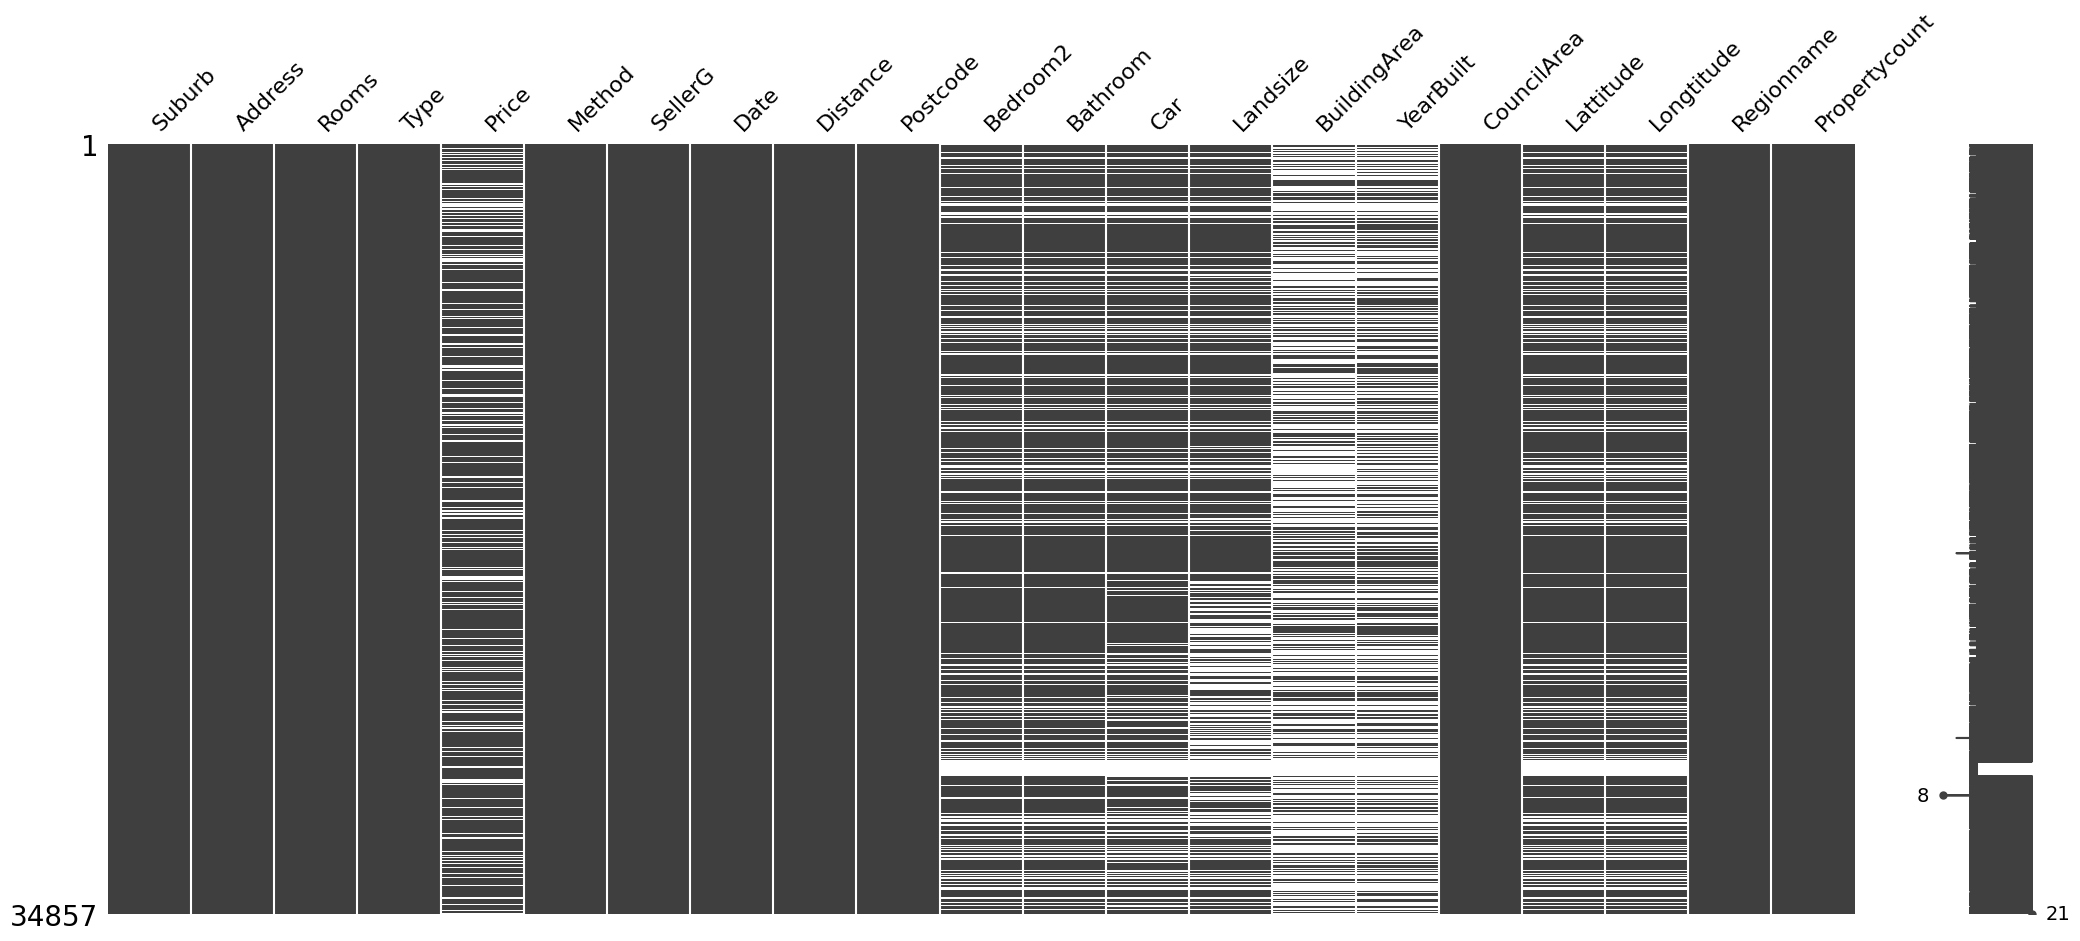

In [7]:
!pip install missingno
import missingno

missingno.matrix(full_data)

In [ ]:
# linear regression: price | Suburb, Landsize,

In [10]:
# basics
sum(full_data.duplicated())

1

## 2. Cleaning

In [219]:
full_data = pd.read_csv(data_path + "/data/Melbourne_housing_FULL.csv")

# basics
sum(full_data.duplicated())

#full_data.head()

1

In [220]:
def preprocess_data(data, one_hot = True):

  # factorize cat varibles
  if one_hot:
      enc = OneHotEncoder(sparse_output=False)  # Use 'sparse_output' instead of 'sparse'
      cat_to_num = enc.fit_transform(data)
      feature_names = enc.get_feature_names_out(data.columns)  # Get the names of one-hot encoded variables
      cat_to_num = pd.DataFrame(cat_to_num, columns=feature_names)

  else:
    cat_to_num = {}
    cat_to_num_labels = []

    for col_name in data.columns:
      cur_col = pd.factorize(data[col_name])
      cat_to_num[col_name] = cur_col[0]
      cat_to_num_labels = col_name[1]

    cat_to_num = pd.DataFrame(cat_to_num)

  return cat_to_num

In [283]:
full_data = full_data[~full_data.duplicated()]

# quick and dirty
full_data = full_data.dropna(axis=0)


# train/test data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

train_data, test_data = train_test_split(full_data,test_size=.2)

y_train = train_data.loc[:,'Price']
y_test = test_data.loc[:,'Price']


In [287]:
def preprocess_data(data, one_hot = True):

  columns_to_keep = ['Rooms', 'Distance']#, 'Landsize','Bedroom2'] #, 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'Regionname'] # 'YearBuilt'

  data = data.loc[:, columns_to_keep]
  cat_data = data.select_dtypes(include='object')

  cat_cols = list(cat_data.columns)
  num_cols = [col for col in columns_to_keep if col not in cat_cols]
  num_data = data.loc[:, num_cols]

  # factorize cat varibles
  enc = OneHotEncoder(sparse_output=False)  # Use 'sparse_output' instead of 'sparse'
  cat_to_num = enc.fit_transform(cat_data)
  feature_names = enc.get_feature_names_out(cat_data.columns)  # Get the names of one-hot encoded variables
  cat_to_num = pd.DataFrame(cat_to_num, columns=feature_names)
  #cat_to_num = preprocess_data(cat_data)

  # rescale num variables
  from sklearn.preprocessing import MaxAbsScaler

  scaler = MaxAbsScaler()
  scaled_num = scaler.fit_transform(num_data)

  scaled_num = pd.DataFrame(scaled_num)
  scaled_num.columns = num_cols

  processed_data = pd.concat((cat_to_num, scaled_num), axis=1)

  return processed_data


## 3. Exploratory Analysis

## 4. Model Building

In [262]:
from sklearn.base import clone
from sklearn.metrics import f1_score
from sklearn import metrics
from torch.utils.data import Subset, Dataset
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [288]:
processed_train = preprocess_data(train_data)
processed_test = preprocess_data(test_data)

models = {'linear_regression': LinearRegression(),
          'svr': SVR(),
          'tree_regressor': DecisionTreeRegressor(),
          'forest_regressor': RandomForestRegressor(n_estimators=500, max_leaf_nodes=16)}


def train_model(X_train, y_train, X_test, y_test, model):
  cur_model = models[model]
  cur_model.fit(X_train, y_train)
  predictions = cur_model.predict(X_test)
  #perf[model] = metrics.mean_absolute_error(y_test, predictions)
  perf[model] = metrics.r2_score(y_test, predictions)
  #perf[model] = metrics.d2_absolute_error_score(y_test, predictions)

In [289]:
perf = {}

for model in models.keys():
  train_model(processed_train, y_train, processed_test, y_test, model)

perf


{'linear_regression': -0.5018943713395545,
 'svr': -0.06942297316147084,
 'tree_regressor': -0.5039868215342023,
 'forest_regressor': 0.030016308899196487}

## 5. Iterating